In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = ['Tahoma']
plt.style.use('seaborn-white')  # 'seaborn-ticks'
sns.set_style('white')
import dateutil

from sklearn.preprocessing import StandardScaler

In [2]:
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
# rn.columns = rn.columns.str[:-4]
# fn.columns = fn.columns.str[:-4]
# ri.columns = ri.columns.str[:-4]
# fi.columns = fi.columns.str[:-4]
# rd.columns = rd.columns.str[:-4]
# fd.columns = fd.columns.str[:-4]

order_cols = rn.columns.to_list() + fn.columns.to_list() + \
                ri.columns.to_list() + fi.columns.to_list() + \
                rd.columns.to_list() + fd.columns.to_list()

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [8]:
# colors
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
    
with open(r'..\data\metadata\metab_lipid_class_superclass_color.json', 'r') as infile:
    class_colormap = json.load(infile)

### Make heatmap with 20 columns, clustering on y-axis

In [9]:
# Standardize data
data.loc[:, data_cols] = StandardScaler().fit_transform(data.loc[:, data_cols])
# data.loc[:, data_cols]

# Make file grouping 
hmfg = fg.set_index('combined_col_name')[['animal', 'bg_type']].T
# Make another file grouping
hmfg2 = fg[['animal', 'bg_type', 'gluc_tol']].drop_duplicates().set_index(['bg_type', 'animal'])

d = data.loc[:, order_cols].append(hmfg).T
d = d.groupby(['bg_type', 'animal']).mean()
d = d.join(hmfg2)

# Set metadata as indexes
d.set_index('gluc_tol', append=True, inplace=True)
d.sort_values(['bg_type', 'gluc_tol', 'animal'], ascending=[True, False, True], inplace=True)
d

l_0       l_1       l_2       l_3       l_4  \
bg_type animal gluc_tol                                                     
FBG     1091   normal    0.658193  0.944542  0.718667  1.972213  0.072298   
        1093   normal    0.582896  1.088961  0.595267  1.983369  0.257411   
        1060   impaired  0.627583  1.177346  0.745092  2.021367  0.467008   
        1062   impaired  0.517778  0.992269  0.571426  1.966271  0.267027   
        1074   impaired  0.420240  0.890599  0.726746  2.090372  0.179301   
        1092   impaired  0.521512  1.083607  0.619972  1.991530  0.273998   
        1102   impaired  0.549985  1.088480  0.698838  1.882185  0.255397   
        1076   diabetic  0.263949  0.615316  0.430176  1.650632 -0.224592   
        1082   diabetic  0.649759  1.178083  0.880686  2.024017  0.244519   
        1101   diabetic  0.531250  1.107757  0.756140  1.986287  0.348034   
RBG     1091   normal    0.887272  1.247744  0.688818  2.160258  0.350685   
        1093   normal    0.688521  1.064403  0.821354  2.009488  0.355518   
        1060   impaired  0.725860  1.206625  0.813709  1.947588  0.444065   
        1062   impaired  0.403773  0.579232  0.637179  2.021118  0.270295   
        1074   impaired  0.748465  1.193252  0.817260  2.133756  0.481352   
        1092   impaired  0.828251  1.204344  0.867798  2.053171  0.266172   
        1102   impaired  0.473955  0.674217  0.556168  1.955514  0.134988   
        1076   diabetic  0.503930  0.767384  0.796187  1.871793  0.301450   
        1082   diabetic  0.505727  0.876875  0.596706  1.971974  0.208802   
        1101   diabetic  0.600213  1.072227  0.677169  2.120861  0.275077   

                              l_5       l_6       l_7       l_8       l_9  \
bg_type animal gluc_tol                                                     
FBG     1091   normal    1.732007  3.290954  0.195351  1.716719  0.922611   
        1093   normal    1.820602  3.192389  0.182152  1.571707  0.705476   
        1060   impaired  1.949313  3.329612  0.172992  1.645939  0.827470   
        1062   impaired  1.650971  3.199877  0.081931  1.571126  0.628333   
        1074   impaired  1.745678  3.290150  0.154130  1.645689  0.720403   
        1092   impaired  1.828682  3.159777  0.153252  1.551269  0.651968   
        1102   impaired  1.839403  3.330699 -0.164134  1.612565  0.572181   
        1076   diabetic  1.474347  3.043705 -0.247896  1.431097  0.346336   
        1082   diabetic  1.816268  3.218756  0.282643  1.674557  0.865110   
        1101   diabetic  1.899387  3.182927  0.085577  1.566378  0.746925   
RBG     1091   normal    1.800076  3.193886  0.233039  1.625315  0.645788   
        1093   normal    1.742154  3.093593  0.129437  1.504082  0.624608   
        1060   impaired  1.797370  3.373536  0.019501  1.648350  0.628866   
        1062   impaired  1.457778  3.175050  0.066305  1.561007  0.514992   
        1074   impaired  1.891247  3.274192  0.093073  1.611810  0.691187   
        1092   impaired  1.876388  3.211296  0.179391  1.634891  0.766959   
        1102   impaired  1.666232  3.027925 -0.027558  1.379658  0.305270   
        1076   diabetic  1.740561  3.150770 -0.114839  1.559948  0.600895   
        1082   diabetic  1.614873  3.145254 -0.106932  1.443070  0.303848   
        1101   diabetic  1.786211  3.139131  0.187285  1.534844  0.460442   

                         ...     m_682     m_368     m_340     m_616  \
bg_type animal gluc_tol  ...                                           
FBG     1091   normal    ... -0.539483  0.410606  0.453191 -0.472971   
        1093   normal    ... -0.651428  0.308930  0.339819 -0.754844   
        1060   impaired  ... -0.727322  0.196547  0.218683 -1.007176   
        1062   impaired  ... -0.864268  0.165062  0.180189 -1.032448   
        1074   impaired  ... -0.540860  0.349850  0.403390 -0.795858   
        1092   impaired  ... -0.690295  0.278217  0.291666 -0.827747   
        1102   impaired  ... -0.733837  0.220646  0.275036 -1.08

In [10]:
lm_class = data[['Compound Class']]
lm_class.loc[:, 'd'] = lm_class['Compound Class'].map(class_colormap)
lm_class.loc[:, 'color'] = lm_class['d'].str[0]
lm_class.loc[:, 'superclass'] = lm_class['d'].str[1]
lm_class.drop('d', inplace=True, axis=1)
lm_class

C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Compound Class,color,superclass
i,,,
l_0,unknown,"[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_1,unknown,"[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_2,unknown,"[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_3,unknown,"[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
l_4,unknown,"[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
...,...,...,...
m_169,unknown,"[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
m_213,unknown,"[0.4980392156862745, 0.4980392156862745, 0.498...",Unidentified
m_24,CA,"[0.5490196078431373, 0.33725490196078434, 0.29...",Carboxylic Acid


l_0          (0.4, 0.7607843137254902, 0.6470588235294118)
l_1          (0.4, 0.7607843137254902, 0.6470588235294118)
l_2          (0.4, 0.7607843137254902, 0.6470588235294118)
l_3          (0.4, 0.7607843137254902, 0.6470588235294118)
l_4          (0.4, 0.7607843137254902, 0.6470588235294118)
                               ...                        
m_169    (0.9882352941176471, 0.5529411764705883, 0.384...
m_213    (0.9882352941176471, 0.5529411764705883, 0.384...
m_24     (0.9882352941176471, 0.5529411764705883, 0.384...
m_505    (0.9882352941176471, 0.5529411764705883, 0.384...
m_441    (0.9882352941176471, 0.5529411764705883, 0.384...
Length: 1727, dtype: object

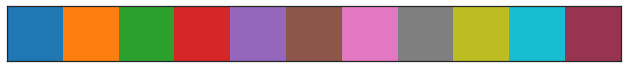

In [14]:
# Lipid or Metabolite label and colormap
lm_pal = sns.color_palette('Set2', n_colors=2)

lm_colormap = pd.Series({x: (lm_pal[0] if x[0] == 'l' else lm_pal[1]) for x in d.columns})
display(lm_colormap)

# Vanessa's LipidGenie categorization 
# purple = glycerolipid = TG, DG, alk-DG
# red = fatty acyl
# gray = unid
# blue = sterol lipid
# yellow = sphingolipid
# green = phospholipid
# 0 = Blue         Sterol lipid
# 1 = Orange       Sphingolipid
# 2 = Green        Phospholipid
# 3 = Red          FA
# 4 = Purple       Glycerolipid
# 5 = Brown        Carboxylic Acid
# 6 = Pink         Amino Acid
# 7 = Gray         Unidentified
# 8 = Olive green  Amine/Amide/Ammonium/N-heterocycle
# 9 = Light Blue   
# 10 = Maroon-ish  Other Metabolite

p = sns.color_palette(n_colors=10)
p.append(sns.color_palette('twilight_r', n_colors=15)[4])
sns.palplot(p)
class_colormap = {
    # LIPIDS
    "TG":           (p[4], 'Glycerolipid'),
    "Alkenyl-DG":   (p[4], 'Glycerolipid'),
    "AC":           (p[3], 'Fatty Acyl'),
    "FA":           (p[3], 'Fatty Acyl'),
    "CE":           (p[0], 'Sterol Lipid'),
    "SM":           (p[1], 'Sphingolipid'),
    "Cer[NS]":      (p[1], 'Sphingolipid'),
    "LysoPE":       (p[2], 'Phospholipid'),
    "LysoPC":       (p[2], 'Phospholipid'),
    "PC":           (p[2], 'Phospholipid'),
    "PI":           (p[2], 'Phospholipid'),
    "Plasmenyl-PC": (p[2], 'Phospholipid'),
    "Plasmanyl-PC": (p[2], 'Phospholipid'),
    "Plasmenyl-PE": (p[2], 'Phospholipid'),
    "PE":           (p[2], 'Phospholipid'),
    "Plasmanyl-PE": (p[2], 'Phospholipid'),
    
    # METABOLITES
    "CA":           (p[5], 'Carboxylic Acid'),
    "AA":           (p[6], 'Amino Acid'),
    "amine"      :  (p[8], 'Amine/Amide/Ammonium/N-heterocycle'),
    "TAA"        :  (p[8], 'Amine/Amide/Ammonium/N-heterocycle'),
    "lactam"     :  (p[8], 'Amine/Amide/Ammonium/N-heterocycle'),
    "niacin"     :  (p[8], 'Amine/Amide/Ammonium/N-heterocycle'),
    "purine"     :  (p[8], 'Amine/Amide/Ammonium/N-heterocycle'),
    "amide"      :  (p[8], 'Amine/Amide/Ammonium/N-heterocycle'),
    "plasticizer":  (p[10], 'Other Metabolite'),
    "coumarin"   :  (p[10], 'Other Metabolite'),
    "sugar"      :  (p[10], 'Other Metabolite'),
    "chromenone" :  (p[10], 'Other Metabolite'),
    "other"      :  (p[10], 'Other Metabolite'),
    
    "unknown":      (p[7], 'Unidentified'),
}

superclass_colormap = {}
for color, superclass in class_colormap.values():
    superclass_colormap[superclass] = color
superclass_colormap

lm_colormap = pd.Series({x: (lm_pal[0] if x[0] == 'l' else lm_pal[1]) for x in d.columns})

# Write class_colormap to file 
with open(r'..\data\metadata\metab_lipid_class_superclass_color.json', 'w') as outfile:
    json.dump(class_colormap, outfile)

In [15]:
display(sns.color_palette('colorblind', 15))
blindcolor = sns.color_palette('colorblind', 15)
rbg_color = blindcolor[0]
fbg_color = blindcolor[1]
normal_color = blindcolor[2]
impaired_color = blindcolor[7]
diabetic_color = blindcolor[4]

bgs = []
gluc_tols = []
for bg, animal, gluc_tol in d.index:
    if bg == 'RBG':
        bgs.append(rbg_color)
    elif bg == 'FBG':
        bgs.append(fbg_color)
    if gluc_tol == 'normal':
        gluc_tols.append(normal_color)
    elif gluc_tol == 'impaired':
        gluc_tols.append(impaired_color)
    elif gluc_tol == 'diabetic':
        gluc_tols.append(diabetic_color)
col_colors = [bgs, gluc_tols]

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

In [16]:
bgs

[(0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.00392156862745098, 0.45098039215686275, 0

In [17]:
lm_colormap

l_0          (0.4, 0.7607843137254902, 0.6470588235294118)
l_1          (0.4, 0.7607843137254902, 0.6470588235294118)
l_2          (0.4, 0.7607843137254902, 0.6470588235294118)
l_3          (0.4, 0.7607843137254902, 0.6470588235294118)
l_4          (0.4, 0.7607843137254902, 0.6470588235294118)
                               ...                        
m_169    (0.9882352941176471, 0.5529411764705883, 0.384...
m_213    (0.9882352941176471, 0.5529411764705883, 0.384...
m_24     (0.9882352941176471, 0.5529411764705883, 0.384...
m_505    (0.9882352941176471, 0.5529411764705883, 0.384...
m_441    (0.9882352941176471, 0.5529411764705883, 0.384...
Length: 1727, dtype: object

In [18]:
data['RT [min]'] < 0.6

i
l_0       True
l_1       True
l_2       True
l_3       True
l_4       True
         ...  
m_169    False
m_213    False
m_24     False
m_505    False
m_441    False
Name: RT [min], Length: 1727, dtype: bool

Text(0.5, 1.0, 'Heatmap')

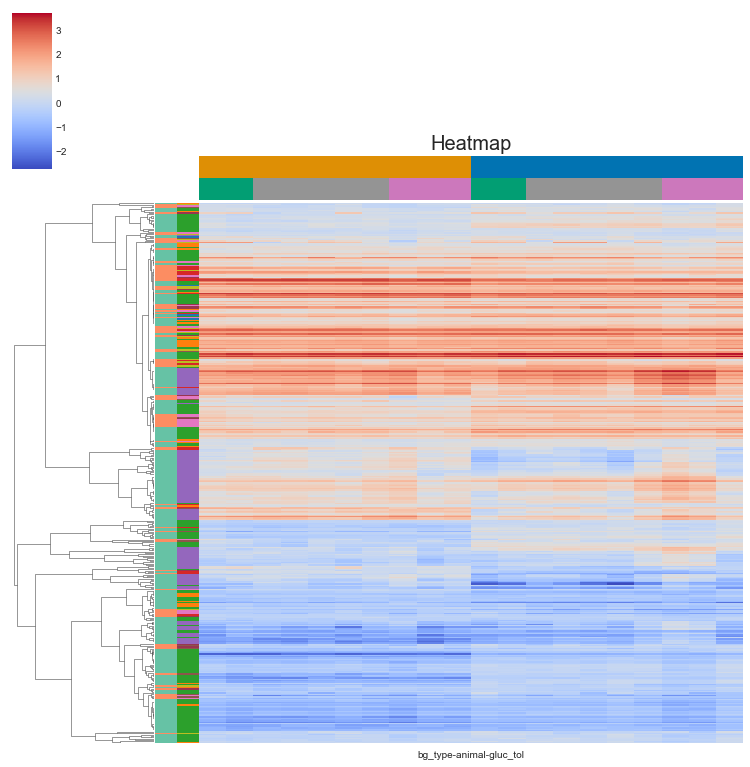

In [47]:
no_unknowns = data['Proposed ID'] != 'unknown'
signif_sampling = data['fdr corrected pval effect of sampling'] < 0.05
quick_test = data['RT [min]'] < 0.6

fig = sns.clustermap(
    #                data=d.T, 
    #                row_colors=[lm_colormap, lm_class['color']],
    data=d.T[no_unknowns],
    method='complete',
    metric='cosine',  # 'cosine', 'correlation'
#     z_score=1,
    row_colors=[lm_colormap[no_unknowns], lm_class['color'][no_unknowns]],
    #                data=d.T[quick_test],
    #                row_colors=[lm_colormap[quick_test], lm_class['color'][quick_test]],
    cmap='coolwarm',
    col_cluster=False,
    col_colors=col_colors,
    figsize=(11, 12),
               )
cbar = fig.ax_cbar
hm = fig.ax_heatmap
dg = fig.ax_row_dendrogram
cc = fig.ax_col_colors
rc = fig.ax_row_colors

hm.set_yticklabels([])
hm.set_xticklabels([])

cc.set_title('Heatmap', fontsize=20)
# cc.legend()
# rc.legend()

# plt.savefig(r'..\reports\figures\4-3-2\RvF_metadata_heatmap.svg')